### Garrick Chu's Solution to Ultimate Data's Take Home Challenge (April 2018)

Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [3]:
#import relevant libraries and packages for EDA, reading in files
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

In [4]:
# declaring the paths for the files
target_file_path = r'''C:\Users\Garrick\Documents\Springboard\Curriculum\Section 20 - Effective Interviewing for Data Scientist\20.1 - The Take Home Challenge\ultimate_challenge\logins.json'''

ultimate_DS_challenge = r'''C:\Users\Garrick\Documents\Springboard\Curriculum\Section 20 - Effective Interviewing for Data Scientist\20.1 - The Take Home Challenge\ultimate_challenge\ultimate_data_challenge.json'''

In [5]:
# taking a peek at our data before loading in for further manipulation, getting a feel for size and scope of data
with open(ultimate_DS_challenge, 'r') as json_file:
    ultimate_ds = json.load(json_file)

print(type(ultimate_ds))

<class 'list'>


In [6]:
print(len(ultimate_ds))

50000


In [7]:
with open(target_file_path, 'r') as json_file:
    logins = json.load(json_file)

print(type(logins))

<class 'dict'>


In [8]:
len(logins['login_time'])

93142

In [9]:
print(json_normalize(logins).head(10))

                                          login_time
0  [1970-01-01 20:13:18, 1970-01-01 20:16:10, 197...


In [8]:
# addressing Part 1: Visualize and Describe logins in 15 min intervals

logins = pd.read_json(target_file_path)
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [9]:
# need to aggregate dataframe into 15 min intervals
# first, want to utilize pandas datetime functionality to manipulate.  need to set the index with associated date time data

logins.set_index(logins['login_time'], inplace=True)
logins.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [10]:
# next, using Grouper method to aggregate rows by 15 minutes and count row-wise elements in each interval

logins.groupby(pd.Grouper(freq='15Min'))
logins_resamp = logins.resample('15Min').count()
logins_resamp.head()

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Count of Intervals with respective logins')

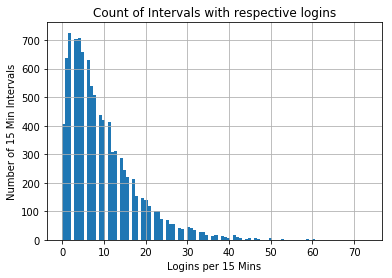

In [12]:
logins_resamp.hist(bins=100)
plt.xlabel('Logins per 15 Mins')
plt.ylabel('Number of 15 Min Intervals')
plt.title('Count of Intervals with respective logins')

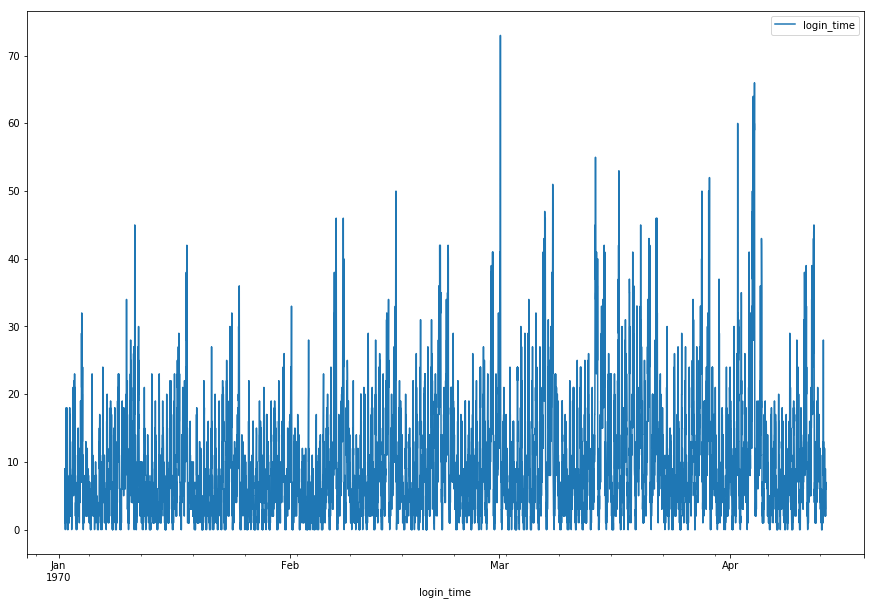

In [13]:
# let's look at the frequency across the entire data 'logins' dataset

logins_resamp.plot(figsize=(15,10))
plt.show()

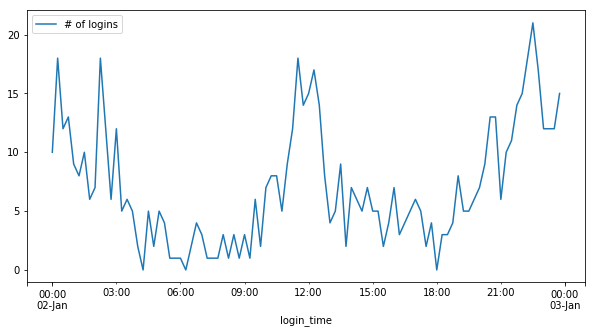

In [14]:
# lets see what just a day looks like, appears we can pick aribitrarily given the above plot

logins_resamp['1970-01-02': '1970-01-02'].plot(figsize=(10,5))
plt.legend(['# of logins'])
plt.show()

Assuming local time, it seems a lot of users are logging in late at night/early morning. There is also a steady increase as the morning starts and peaks around Noon (perhaps users get logged out by default or log in after a morning full of meetings).  

It seems that this app is a ride-sharing app and the activity makes sense... especially for the day after new years.  We see users logging in from 9 PM to 3 AM as users find rides (props to responsible partygoers).  We also see a surge in activity between 11 AM and 1 PM, or peak lunch hour.  This activity could be users getting rides to and from their desired lunch spot or drivers logging in for meal delivery service (ie UberEats).  

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

1a.  I would choose 4 primary metrics, two which focus on user engagement and two which focus on company profitability.  In the user engagement category, I would measure customer satisfcation (as a measure of whether customers gain from more driver availability) which would be measured by rider rating, and driver partner satisfaction (by driver partner satisfaction with Ultimate and number of logins (I would choose this metric in favor of driver time since it stands that their drive time should be increased as a result of this pilot program).  

The other metrics category would focus on product profitability and I intend to measure: customer wait times and profits (net of toll subsidy and operating costs).   I would initially focus on these two metrics as customer wait times would be a proxy for whether the product is improving with respect to increased driver availability for riders and also whether it makes financial sense to implement this subsidy.  I am assuming these metrics are easily obtainable and measurable and commensurate with each event in the pilot program. 

Other ideas for metrics to measure include: sign-up rates, ride-cancel rates, numbers of complaints. 

Success would be defined as finding a statistically significant improvement in these 4 primary metrics over the control group (users and riders not subject to the toll subsidy).

2. I would design an A/B test where a small subsample of driver partners from both Gotham and Metropolis would be invited for this trial program as to obtain a representative sample.   I would structure the test to run for a 6 month period (to factor our seasonality and to have substantial data). I would compare the aforementioned metrics from the control group to the test group and see if the difference in metrics is statistically significant to impliment this or maintain the status quo.  

For example, I would segment average customer wait times by certain times of day (such as peak rush hours) from both control and test groups and determine if there is a statisical beneficial difference in wait times.

I would then design hypothesis tests for the above 4 metrics since these results are likely of concern to the managers of city operations.  Using the control groups metrics, obtain the base statitics (mean driver ratings of riders, driver partner satisfaction, customer wait times and net profits per ride) and compare the statistics of the test group and determine if there is a statistically significant difference.  For example, if the mean customer wait time of the test group falls out of the 95% confidence interval of the control group, this suggests that the pilot program makes a significant difference in our product.

Lastly, based on the results of the models and tests, I would present the findings at a high level along with recommendations to roll-out this program to all driver partners or discontinue.  I would also present other recommendations such as a limited-time mode during special events or seasons instead of offering year-round or limit the program's scope to select drivers.

### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [10]:
# loading the dataset into a pandas dataframe for cleaning, munging and analysis

df = pd.DataFrame(ultimate_ds)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [11]:
# lets clean if needed...

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Looks like we have some Nulls in the ratings and phone type.  If a user doesn't have an average rating, that could mean they have only taken 1 trip (can't take an average of one number).  Let's examine this...

In [12]:
df.sort_values(by='avg_rating_of_driver', na_position='first').head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6,3.95,4.0,NaN,1.0,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
9,2.37,5.0,NaN,1.0,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0
12,20.29,5.0,NaN,1.0,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0
14,26.01,5.0,NaN,1.0,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0
15,13.20,5.0,NaN,1.0,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0
20,2.53,3.0,NaN,1.0,Winterfell,2014-03-16,Android,2014-01-31,0.0,1,False,50.0
21,3.31,5.0,NaN,1.0,Astapor,2014-04-29,iPhone,2014-01-09,0.0,1,False,100.0
22,11.47,5.0,NaN,1.0,Winterfell,2014-05-02,iPhone,2014-01-24,0.0,0,False,100.0
25,14.48,5.0,NaN,1.0,Winterfell,2014-01-03,iPhone,2014-01-02,0.0,1,True,100.0
28,5.97,5.0,NaN,1.5,Winterfell,2014-06-08,iPhone,2014-01-19,100.0,0,False,0.0


It seems these users just do not tend to leave a rating (or perhaps ratings are in dispute).  In any case, I believe we can keep this NaNs in and replace/assume with the mean value.

In [13]:
# repeat for avg_rating_of_driver

df.sort_values(by='avg_rating_by_driver', na_position='first').head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
90,6.28,NaN,5.0,1.00,Winterfell,2014-02-09,iPhone,2014-01-10,0.0,1,False,0.0
274,6.00,NaN,2.0,4.00,Astapor,2014-02-09,iPhone,2014-01-25,100.0,1,False,0.0
277,1.82,NaN,NaN,1.00,Winterfell,2014-01-26,iPhone,2014-01-25,0.0,1,False,0.0
536,1.41,NaN,5.0,1.00,Winterfell,2014-02-08,Android,2014-01-18,0.0,1,False,100.0
857,0.42,NaN,4.0,1.00,Winterfell,2014-03-16,iPhone,2014-01-11,0.0,0,False,0.0
1021,2.33,NaN,NaN,1.75,King's Landing,2014-06-13,iPhone,2014-01-23,100.0,0,True,100.0
1073,9.21,NaN,5.0,1.00,King's Landing,2014-04-27,Android,2014-01-19,0.0,0,False,0.0
1164,2.57,NaN,2.0,1.00,Winterfell,2014-01-25,Android,2014-01-24,0.0,1,True,100.0
1181,24.91,NaN,3.0,1.00,Winterfell,2014-01-25,Android,2014-01-25,0.0,1,False,0.0
1205,8.94,NaN,NaN,1.00,Winterfell,2014-02-22,Android,2014-01-18,0.0,0,False,100.0


Looks like we can use the same method of filling the mean value for the 'avg_rating_by_driver' Null vals.  

In [14]:
df_clean = df
df_clean['avg_rating_by_driver'].fillna(df_clean['avg_rating_by_driver'].mean(), inplace=True)
df_clean['avg_rating_of_driver'].fillna(df_clean['avg_rating_of_driver'].mean(), inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
# let's also examine the phone column and clean as neeeded, current as dtype = 'object'
df_clean['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [17]:
df_clean['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

Since just 400 values, a relatively small proportion, have None as value, we can skip for the sake of time.  We can come back to this later if needed...

In [38]:
# next need to add a column which labels a user as active within the 6 month window

# convert last_trip_date col to datetime
df_clean['last_trip_date'] = pd.to_datetime(df_clean['last_trip_date'])

# convert signup col to datetime
df_clean['signup_date'] = pd.to_datetime(df_clean['signup_date'])

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [39]:
df_clean['6_mo_active'] = np.where(df_clean['last_trip_date']>='2014-5-31', 1, 0) 
# given "active" is having used within 30 days and pulled 6 months later
df_clean.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,6_mo_active
0,3.67,5.0,4.700000,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.000000,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.300000,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.600000,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.400000,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0
5,10.56,5.0,3.500000,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,1
6,3.95,4.0,4.601559,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,0
7,2.04,5.0,5.000000,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,0
8,4.36,5.0,4.500000,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,0
9,2.37,5.0,4.601559,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,0


In [40]:
df_clean.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,6_mo_active
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084,0.384460
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,37.081503,0.486472
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000,0.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000


Looks like there could be some outlier data especially with the average distance and number of trips in first 30 days.

In [41]:
df.sort_values(by='avg_dist', ascending=False).head(10)
# these outliers look okay and don't appear to be incorrect data

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,6_mo_active
20701,160.96,4.778158,4.601559,1.0,Astapor,2014-06-26,Android,2014-01-25,0.0,0,False,100.0,1
534,129.89,5.000000,4.601559,1.0,King's Landing,2014-03-09,None,2014-01-04,0.0,0,False,0.0,0
1302,79.69,5.000000,5.000000,1.0,Winterfell,2014-01-30,iPhone,2014-01-30,0.0,1,False,100.0,0
22290,79.34,5.000000,5.000000,1.0,Astapor,2014-06-26,iPhone,2014-01-12,0.0,0,True,100.0,1
47595,77.13,5.000000,5.000000,1.0,King's Landing,2014-06-09,iPhone,2014-01-25,0.0,0,True,0.0,1
36625,73.88,3.000000,5.000000,1.0,Astapor,2014-01-22,iPhone,2014-01-19,0.0,2,False,100.0,0
22096,72.20,5.000000,4.601559,1.0,Astapor,2014-05-01,iPhone,2014-01-17,0.0,0,True,100.0,0
1493,72.08,5.000000,5.000000,1.0,Astapor,2014-01-27,iPhone,2014-01-26,0.0,1,False,100.0,0
19197,71.38,5.000000,4.700000,1.0,Astapor,2014-05-14,iPhone,2014-01-17,0.0,2,True,100.0,0
42835,70.48,5.000000,5.000000,1.0,Winterfell,2014-06-28,Android,2014-01-10,0.0,0,False,100.0,1


In [42]:
df.sort_values(by='trips_in_first_30_days', ascending=False).head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,6_mo_active
18514,2.02,4.8,5.0,1.12,King's Landing,2014-06-30,iPhone,2014-01-02,14.4,125,True,72.0,1
99,2.86,4.9,4.9,1.00,Astapor,2014-03-05,Android,2014-01-27,0.0,73,True,89.7,0
3030,2.32,4.8,4.9,1.06,Winterfell,2014-06-28,iPhone,2014-01-06,2.9,71,True,85.9,1
29070,1.45,4.6,4.0,1.07,Astapor,2014-06-29,iPhone,2014-01-10,7.3,63,True,83.3,1
48804,2.30,4.7,4.4,1.04,Astapor,2014-06-05,iPhone,2014-01-24,3.1,58,True,77.6,1
45489,3.65,4.4,4.8,1.01,Astapor,2014-04-23,iPhone,2014-01-28,1.3,56,True,78.8,0
36917,3.51,4.8,4.8,1.01,Winterfell,2014-06-30,iPhone,2014-01-26,2.2,56,False,73.1,1
29043,3.39,4.6,4.8,1.03,King's Landing,2014-06-30,iPhone,2014-01-22,4.8,55,True,66.5,1
17942,3.27,4.7,4.6,1.03,Winterfell,2014-06-25,iPhone,2014-01-07,5.3,55,True,68.0,1
31047,2.19,4.5,4.9,1.10,Winterfell,2014-06-29,iPhone,2014-01-25,9.1,54,True,83.0,1


In [80]:
import seaborn as sns

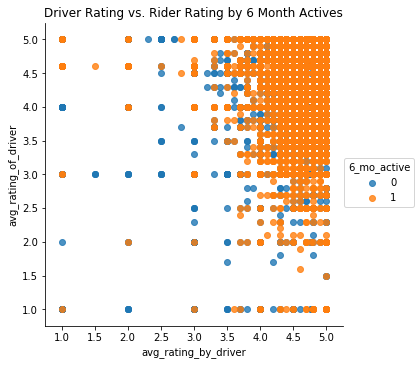

In [81]:
sns.lmplot('avg_rating_by_driver', 'avg_rating_of_driver', data=df_clean, hue='6_mo_active', fit_reg=False)
plt.title('Driver Rating vs. Rider Rating by 6 Month Actives')
plt.show()

It appears riders with better ratings and who rate drivers better tend to be active 6 months after sign up.  We have some outliers where users continually rate drivers badly but continue to use.

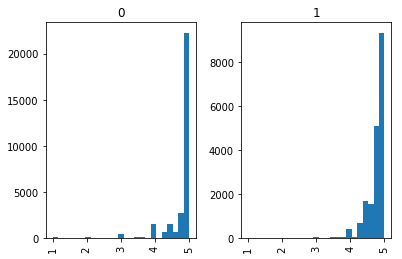

In [107]:
df_clean['avg_rating_by_driver'].hist(by=df_clean['6_mo_active'], bins=25)
plt.show()

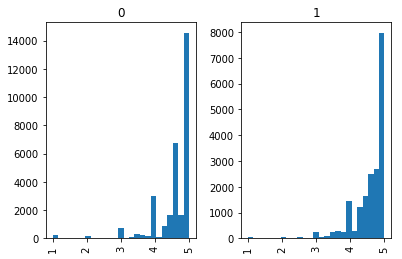

In [108]:
df_clean['avg_rating_of_driver'].hist(by=df_clean['6_mo_active'], bins=25)
plt.show()

Ratings do not appear to be a good predictor... which also makes sense since this data comes in after the fact.  How about other features?

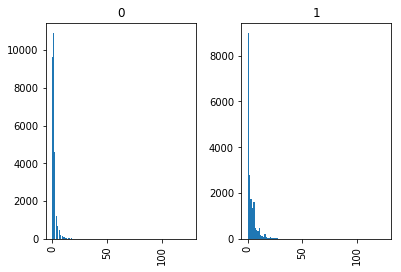

In [112]:
df_clean['trips_in_first_30_days'].hist(by=df_clean['6_mo_active'], sharex=True, bins=100)
plt.show()

In [43]:
# looking into the categorical values including city, phone, and ultimate_black user
# checking if phone type is a factor

pd.crosstab(df_clean['phone'], df_clean['6_mo_active'], margins=True)

6_mo_active,0,1,All
phone,,,
Android,11724,3298,15022
iPhone,18790,15792,34582
All,30514,19090,49604


It seems that Android users tend to not be active 6 months after sign up.  This could be due to user conversion from Android to iOS
or indication of a poor Android UX

Android 6 Month retention rate: 21.9%
iPhone 6 Month retention rate: 45.6%
January Sign-up composition:
Android: 30.2%
iPhone: 69.7%

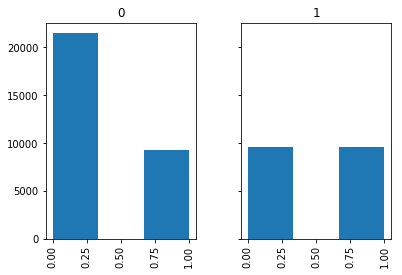

In [47]:
# what about ultimate_black user

df_clean['ultimate_black_user'].hist(by=df_clean['6_mo_active'], sharey=True, bins=3)
plt.show()

The above plot suggests that Ultimate_black service level doesn't appear to have any bearing on users that are active 6 months after sign up.  However, of the inactive users, non-Ultimate Black users outnumber 2:1. 

In [54]:
pd.crosstab(df_clean['ultimate_black_user'], df_clean['6_mo_active'], margins=True)

6_mo_active,0,1,All
ultimate_black_user,,,
False,21535,9611,31146
True,9242,9612,18854
All,30777,19223,50000


6_mo_active         0      1    All
city                               
Astapor         12137   4397  16534
King's Landing   3721   6409  10130
Winterfell      14919   8417  23336
All             30777  19223  50000


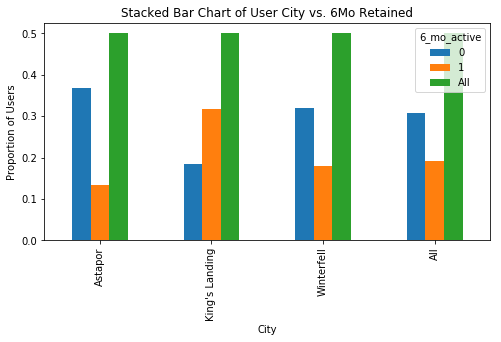

In [74]:
city_tab = pd.crosstab(df_clean['city'], df_clean['6_mo_active'], margins=True)
print(city_tab)
city_tab.div(city_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=False, figsize=(8,4))
plt.title('Stacked Bar Chart of User City vs. 6Mo Retained')
plt.xlabel('City')
plt.ylabel('Proportion of Users')
plt.show()

In [64]:
# can continue exploring visually but let's leverage the modules for feature selection.

# let's check out what our baseline is for 6 month retention

total_active = df_clean['6_mo_active'].sum()
pct_active = (total_active/50000) *100
print("From our subset of 50,000 sign-ups in January, {0:.2f}% were active after 6 Months".format(pct_active))

From our subset of 50,000 sign-ups in January, 38.45% were active after 6 Months


In [77]:
# need to one_hot_encode the categorical values of phone, city and user into numeric
df_2 = pd.get_dummies(df_clean, prefix='one_hot', columns=['city', 'phone','ultimate_black_user'])
df_2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,6_mo_active,one_hot_Astapor,one_hot_King's Landing,one_hot_Winterfell,one_hot_Android,one_hot_iPhone,one_hot_False,one_hot_True
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,46.2,1,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,100.0,0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,80.0,1,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,82.4,0,0,0,1,1,0,1,0


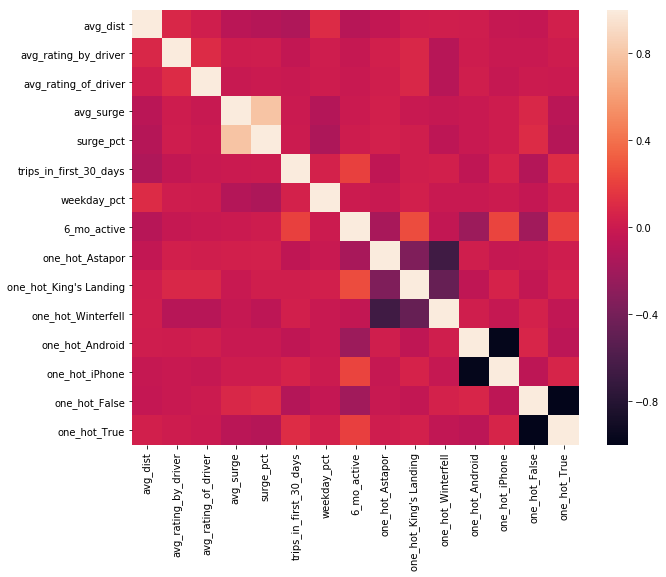

In [84]:
corr = df_2.corr()

fig, ax = plt.subplots(figsize=(10,8))  
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.show()

In [100]:
feature_cols = list(df_2.columns.values)
feature_cols.remove('6_mo_active')
feature_cols.remove('last_trip_date')
feature_cols.remove('signup_date')
feature_cols

['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'trips_in_first_30_days',
 'weekday_pct',
 'one_hot_Astapor',
 "one_hot_King's Landing",
 'one_hot_Winterfell',
 'one_hot_Android',
 'one_hot_iPhone',
 'one_hot_False',
 'one_hot_True']

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_2[feature_cols], df_2['6_mo_active'], test_size=0.2, random_state=16)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 14) (40000,)
(10000, 14) (10000,)


In [106]:
# let's try running a Log Regression without any regularization or additional feature engineering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

LogModel = LogisticRegression()
LogModel.fit(X_train, y_train)
print(accuracy_score(LogModel.predict(X_test), y_test))
from sklearn.metrics import roc_auc_score
print(roc_auc_score(LogModel.predict(X_test), y_test))

0.7087
0.6956421394152521


In [107]:
# let's employ cross-validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=16)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.713


In [112]:
# now let's tune our regularization parameter C by using gridsearch
from sklearn.model_selection import GridSearchCV

Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'C':Cs}

clf_grid = GridSearchCV(LogModel, param_grid, cv=10)
clf_grid.fit(X_train, y_train)

print("Best Parameters: {}".format(clf_grid.best_params_))
print("Best score is {}".format(clf_grid.best_score_))



Best Parameters: {'C': 10}
Best score is 0.713125


In [113]:
print(clf_grid.score(X_test,y_test))

0.7088


In [116]:
#let's implement using SVM, an alternative binary classification method in the even the decision boundary is not linear

from sklearn import svm
SVM = svm.SVC(kernel='linear', C=10, gamma=1) 
SVM.fit(X_train, y_train)
print(accuracy_score(SVM.predict(X_test), y_test))
print(roc_auc_score(SVM.predict(X_test), y_test))

0.7089
0.6992914506451007


In [117]:
SVM_rbf = svm.SVC(kernel='rbf', C=10, gamma=1) 
SVM_rbf.fit(X_train, y_train)
print(accuracy_score(SVM_rbf.predict(X_test), y_test))
print(roc_auc_score(SVM_rbf.predict(X_test), y_test))

0.7233
0.712343262422408


In [130]:
log_coefs = LogModel.coef_
svm_coefs = SVM.coef_

s1 = pd.Series(log_coefs[0], index=feature_cols, name='log_coefs')
s2 = pd.Series(svm_coefs[0], index=feature_cols, name='svm_coefs')

coefs = pd.concat([s1, s2], axis=1)
coefs['coef_delta'] = coefs['log_coefs'] - coefs['svm_coefs']
coefs

,log_coefs,svm_coefs,coef_delta
avg_dist,-0.035682,-0.032794,-0.002888
avg_rating_by_driver,-0.153589,-0.127692,-0.025897
avg_rating_of_driver,-0.074673,-0.107925,0.033252
avg_surge,-0.179855,-0.076113,-0.103742
surge_pct,0.003887,0.003497,0.000390
trips_in_first_30_days,0.119071,0.140640,-0.021569
weekday_pct,-0.000378,-0.001703,0.001324
one_hot_Astapor,-0.632435,-0.765107,0.132672
one_hot_King's Landing,1.041140,1.110404,-0.069264
one_hot_Winterfell,-0.140895,-0.345297,0.204401


Using two different methods (Logistic Regression and Support Vector Machines) for classification, we arrive at fairly similar features in predicting whether users that signed-up in January continued to use the app after 6 months.  Namely, the table suggests that a user's city, phone and whether they use the "Black" service were good representations/predictors.  With these predictors as our model features, we are able to predict with ~70-72% accuracy whether a user will be retained after 6 months of sign-up.  

These findings can be substantially leveraged in maintaining and increasing user rentention.  In fact, the model coefficients aid us in determining what to focus on.  More specifically, it appears Ultimate can focus its efforts in UX/stability for Android users, offer more robust "Black" service (including promotions on service, updating pricing model/scheme, offering more incentives), and (based on what is found out about users in these geographic regions) improving elements of the product that King's Landing users like and Astapor users don't. 

To the last point, my earlier analysis shows that user logins peak in the late night hours... and possibly user wait time plays a considerable factor in user retention.